# Project of handwritten recognition using CNN

starting I import all the libraries that were required including the torch, torchvision for the working on CNN, torchvision for transformation and matplotlib for visualization of the data.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Checking if gpu is present on the device for working

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Variable for the task

In [5]:
input_size = 784  # 28x28 images
hidden_size = 100
num_classes = 10
num_epochs = 2
batch_size = 100
learning_rate = 0.001

Downloading the training and testing dataset. Here using the MNIST inbuild dataset from pytorch.

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform= transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Tensor transformation and normalisation of the data 

In [7]:
# Preprocessing: Transformation and Normalization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST
])

Visualising the data through the sample and further analysing it

In [ ]:
examples = iter(train_loader)
samples, labels = next(examples)
print(samples.shape, labels.shape)

plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(samples[i][0], cmap='gray')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()


torch.Size([100, 1, 28, 28]) torch.Size([100])


Following on I tried to implement the Actual CNN architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

        # LogSoftmax for multi-class classification
        self.output_activation = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # First Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # Second Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the tensor
        x = x.view(-1, 64 * 7 * 7)

        # Fully Connected Layer 1
        x = F.relu(self.fc1(x))

        # Output Layer
        x = self.output_activation(self.fc2(x))
        
        return x

Then I defined the model for this CNN along with the loss and optimizer functions 

I also trained it on the given dataset to establish the results which can be seen in the output of the following code.

In [9]:
model = MNIST_CNN().to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Training the model
num_epochs = 2
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.1838
Epoch [1/2], Step [200/600], Loss: 0.1204
Epoch [1/2], Step [300/600], Loss: 0.1072
Epoch [1/2], Step [400/600], Loss: 0.0689
Epoch [1/2], Step [500/600], Loss: 0.0340
Epoch [1/2], Step [600/600], Loss: 0.0918
Epoch [2/2], Step [100/600], Loss: 0.1061
Epoch [2/2], Step [200/600], Loss: 0.0598
Epoch [2/2], Step [300/600], Loss: 0.0393
Epoch [2/2], Step [400/600], Loss: 0.0101
Epoch [2/2], Step [500/600], Loss: 0.0119
Epoch [2/2], Step [600/600], Loss: 0.0191


Following this let us try to analyse the performance based on the confusion matrix which can be done using the sklearn library.

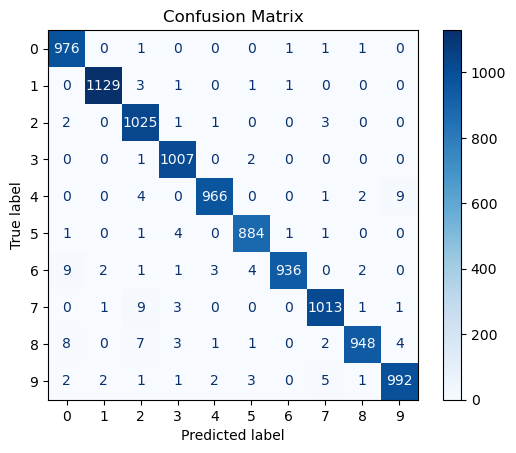

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have the trained model and test_loader
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
